<img align="left" src = https://project.lsst.org/sites/default/files/Rubin-O-Logo_0.png width=250 style="padding: 10px"
alt="Rubin Observatory logo, a graphical representation of turning stars into data."> <br><br>
**Description:** DP1 ComCam Standard Bandpasses <br>
**Authors:** Eli Rykoff, Leanne Guy, Erfan Nourbakhsh <br>
**Last verified to run:** 2025-08-19 <br>
**LSST Science Pipelines version:** v29.1<br>
**Container size:** medium <br>


In [1]:
import matplotlib.pyplot as plt
import numpy as np
from lsst.daf.butler import Butler
from lsst.utils.plotting import get_multiband_plot_colors, publication_plots
from matplotlib import colors as mcolors
from matplotlib import patheffects as pe
from matplotlib.colors import LinearSegmentedColormap

In [2]:
! echo $IMAGE_DESCRIPTION
! eups list -s | grep lsst_distrib

eups                  LOCAL:/cvmfs/sw.lsst.eu/almalinux-x86_64/lsst_distrib/w_2025_29/conda/envs/lsst-scipipe-10.0.0-exact/eups 	setup
lsst_distrib          gdfb3db0272+d933a7c716 	w_latest w_2025_29 current setup


In [3]:
# Set publication style
publication_plots.set_rubin_plotstyle()
colors = get_multiband_plot_colors()
bands = colors.keys()

# Set fill style ("solid" or "gradient")
fill = "gradient"

# Whether to include labels in the legend or put them on top of the curves
labels_in_legend = False

In [4]:
skymapName = "lsst_cells_v1"
instrument = "LSSTComCam"
collections = ["LSSTComCam/DP1/defaults", "LSSTComCam/DP1", "skymaps"]
butler = Butler.from_config(
    "/repo/dp1_prep", instrument="LSSTComCam", collections=collections, skymap=skymapName
)
registry = butler.registry

In [5]:
# Find the right dataset type
dstype_regex = "*band*"
dsTypes = [datasetType for datasetType in registry.queryDatasetTypes(dstype_regex)]
dsTypes

[DatasetType('standard_passband', {band, instrument}, ArrowAstropy)]

In [6]:
# Get the throughputs for ComCam filters by band not 'physical_filter'
# Conceptual passbands, not pieces of glass
throughputs = {}
for band in bands:
    std_bp = butler.get("standard_passband", band=band)
    throughputs[band] = std_bp

In [7]:
# A utility function to plot the gradient under the curve.
def plot_gradient(ax, color, band, wavelengths, tputs, alpha=0.5):
    # Create a vertical gradient under the curve.
    cmap = LinearSegmentedColormap.from_list("grad", ["white", color])

    # Create the gradient image.
    grad = ax.imshow(
        np.linspace(0, 1, 2000).reshape(-1, 1),
        cmap=cmap,
        norm=mcolors.PowerNorm(gamma=0.64),
        extent=[wavelengths.min(), wavelengths.max(), 0, tputs.max()],
        aspect="auto",
        origin="lower",
        alpha=alpha,
        zorder=1,
    )

    # Clip the gradient image to the area under the curve.
    poly = ax.fill_between(wavelengths, 0, tputs, alpha=0)
    grad.set_clip_path(poly.get_paths()[0], transform=ax.transData)
    poly.remove()

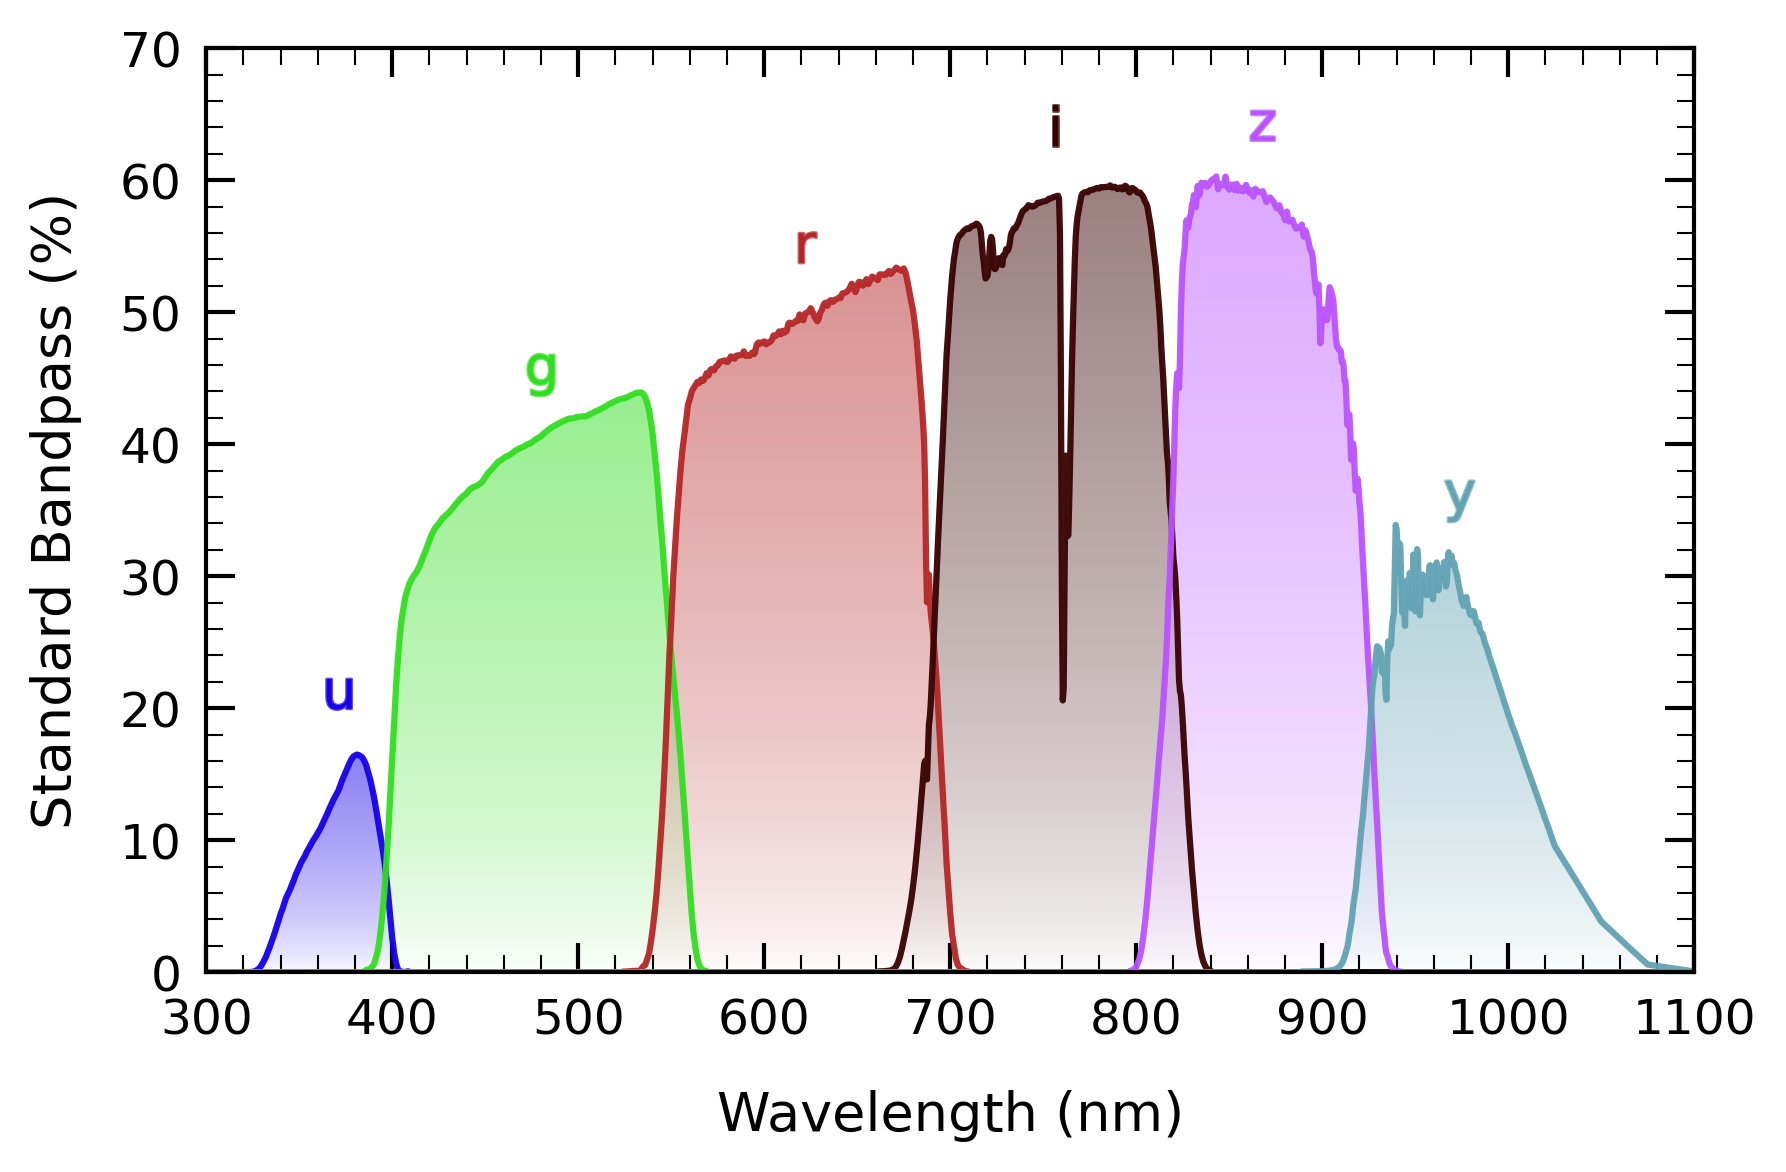

In [ ]:
# Plot the standard bandpasses.
if labels_in_legend:
    fig, ax = plt.subplots()  # i.e. figsize: 6.4, 4.8
else:
    fig, ax = plt.subplots(figsize=(6.4, 4))

for i, (band, std_bp) in enumerate(throughputs.items()):
    color = colors[band[0]]
    wavelengths = std_bp["wavelength"]
    tputs = std_bp["throughput"]
    ax.plot(wavelengths, tputs, lw=1.5, color=color, alpha=0.95, zorder=2)

    if fill == "solid":
        ax.fill_between(wavelengths, tputs, 0, where=tputs > 0, color=color, alpha=0.3, zorder=1)
    elif fill == "gradient":
        plot_gradient(ax, color, band, wavelengths, tputs, alpha=0.5)

    # Place a band label somewhere in the middle of each wavelength range.
    label_wl = np.average(wavelengths, weights=tputs)
    idx = np.argmin(np.abs(wavelengths - label_wl))
    color = colors[band[0]]
    offset = 5.2 if band[0] in ["u", "y"] else 3.0
    ax.text(
        wavelengths[idx],
        tputs[idx] + offset,
        band[0],
        fontsize=13,
        fontweight="normal",
        color=color,
        ha="center",
        va="bottom",
        alpha=1,
        path_effects=[pe.Stroke(linewidth=0.7, foreground=color, alpha=0.7), pe.Normal()],
        zorder=3,
    )

# Add axis labels and adjust limits.
ax.set_xlabel("Wavelength (nm)", fontsize=13, labelpad=11)
ax.set_ylabel("Standard Bandpass (%)", fontsize=13, labelpad=9)
ax.xaxis.set_major_locator(plt.MaxNLocator(nbins=8, prune=None))
ax.yaxis.set_major_locator(plt.MultipleLocator(10))
ax.set_xlim(300, 1100)

if labels_in_legend:
    plt.ylim(0, 80)
    plt.legend(
        loc="upper center", ncols=6, bbox_to_anchor=(0.05, 0.48, 0.88, 0.48), mode="expand", handlelength=3
    )
else:
    ax.set_ylim(0, 70)

plt.savefig("../figures/dp1_comcam_std_bandpasses.pdf", bbox_inches="tight", transparent=True, format="pdf")

In [9]:
# Only close the figure after saving
plt.close()